In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import time
# from scipy.stats import gaussian_kde
# import scipy.stats as stats

In [2]:
from dataset import Step2_DataSet
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset
# from sequence_dataset import SequenceDataset, train_test_split

In [3]:
import kgml_lib

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
# define functions from kgml_lib
Z_norm = kgml_lib.Z_norm 
Z_norm_reverse = kgml_lib.Z_norm_reverse
get_gpu_memory = kgml_lib.get_gpu_memory

In [6]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

input_data = 'recotest_data_scaled_v4_100sample.sav'
sample_index_file = "traindataset_split_year_v1.sav"

pretrained_model = "recotest_v11_exp4.sav_step1"
output_model = "recotest_v11_exp4_sample.sav_step2"
synthetic_data = "sys_data2.sav"

dataset = Step2_DataSet(data_path, input_data, output_path, sample_index_file)
dataset.load_step2_data()

dataset.prepare_step2_data()

torch.Size([6570, 100, 19]) torch.Size([6570, 100, 3]) torch.Size([18, 100, 1])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC']


In [7]:
X = dataset.X  #[365*18, 100, 19]
X = torch.transpose(X,1, 0) #[100, 365*18, 19]

Y1 = dataset.Y1 #[365*18, 100, 3]
Y1 = torch.transpose(Y1,1, 0) #[100, 365*18, 3]

Y2 = dataset.Y2 #[18, 100, 1]
Y2 = torch.transpose(Y2,1, 0)

y_scaler = dataset.Y1_scaler


In [8]:
co2_pretrain_file = data_path + 'co2_pretrain_data.sav'
torch.save({'X': X,
            'Y': Y1,
            'y_scaler': y_scaler}, co2_pretrain_file)

In [9]:
num_input_features = 19
num_output_features = 3

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [10]:
# Choose one of the models below:
#model = LSTMSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)
# model = GRUSeq2Seq(input_dim, hidden_dim, num_layers, output_dim)

# model = EnhancedGRUModel(input_dim, hidden_dim, num_layers, output_dim)

# model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim)

In [11]:
total_years = 18
# days_per_year = 365
# total_days = total_years * days_per_year
# num_sites = X.shape[0] #100

batch_size=64

model.train_test_split(X, Y1, total_years, batch_size, split_method=1)

In [12]:
learning_rate = 0.001
step_size = 20
max_epoch = 60
loss_function = nn.L1Loss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/60 | LR: 0.001000, Train Loss: 0.6498, Test Loss: 0.4913
Epoch 2/60 | LR: 0.001000, Train Loss: 0.4748, Test Loss: 0.4199
Epoch 3/60 | LR: 0.001000, Train Loss: 0.3785, Test Loss: 0.3265
Epoch 4/60 | LR: 0.001000, Train Loss: 0.2993, Test Loss: 0.2731
Epoch 5/60 | LR: 0.001000, Train Loss: 0.2590, Test Loss: 0.2481
Epoch 6/60 | LR: 0.001000, Train Loss: 0.2398, Test Loss: 0.2312
Epoch 7/60 | LR: 0.001000, Train Loss: 0.2256, Test Loss: 0.2215
Epoch 8/60 | LR: 0.001000, Train Loss: 0.2140, Test Loss: 0.2145
Epoch 9/60 | LR: 0.001000, Train Loss: 0.2047, Test Loss: 0.2033
Epoch 10/60 | LR: 0.001000, Train Loss: 0.1953, Test Loss: 0.1945
Epoch 11/60 | LR: 0.001000, Train Loss: 0.1862, Test Loss: 0.1876
Epoch 12/60 | LR: 0.001000, Train Loss: 0.1774, Test Loss: 0.1822
Epoch 13/60 | LR: 0.001000, Train Loss: 0.1731, Test Loss: 0.1771
Epoch 14/60 | LR: 0.001000, Train Loss: 0.1672, Test Loss: 0.1743
Epoch 15/60 | LR: 0.001000, Train Loss: 0.1635, Test Loss: 0.1743
Epoch 16/60 | LR: 0

In [13]:
model.test()

Test Loss: 0.1534


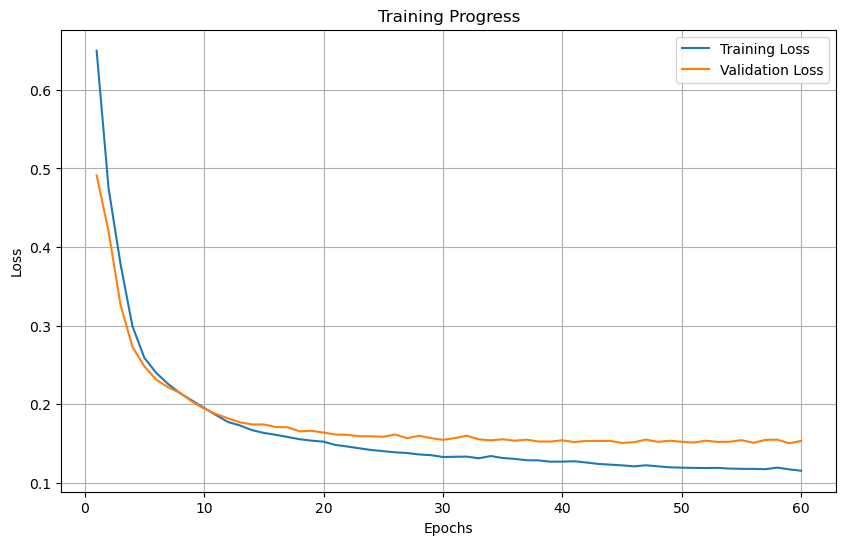

In [14]:
model.plot_training_curves()

In [15]:
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.9511289680464393
Feature Rh R2 Score is: 0.8176458341473201
Feature NEE R2 Score is: 0.9545826737137187


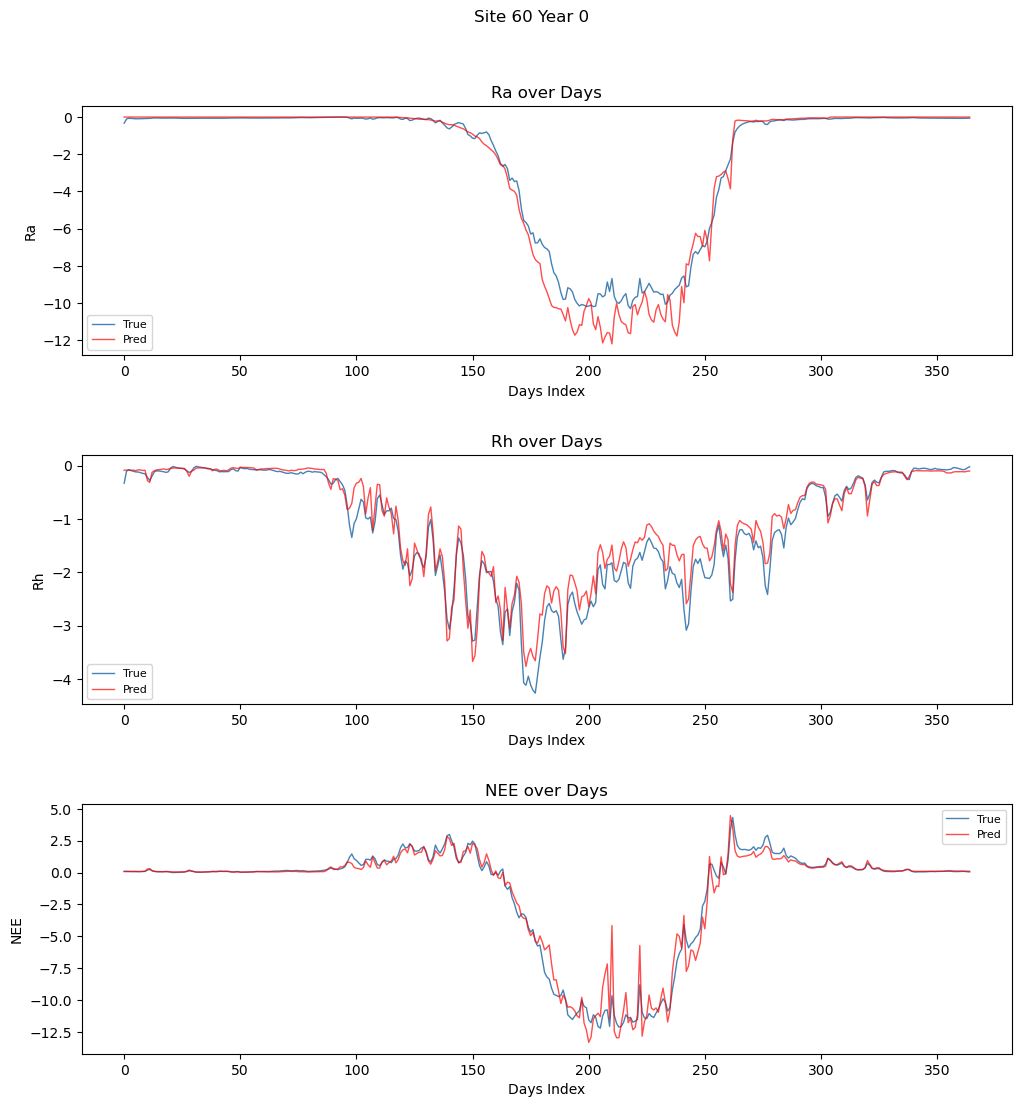

In [16]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=60, year=0)

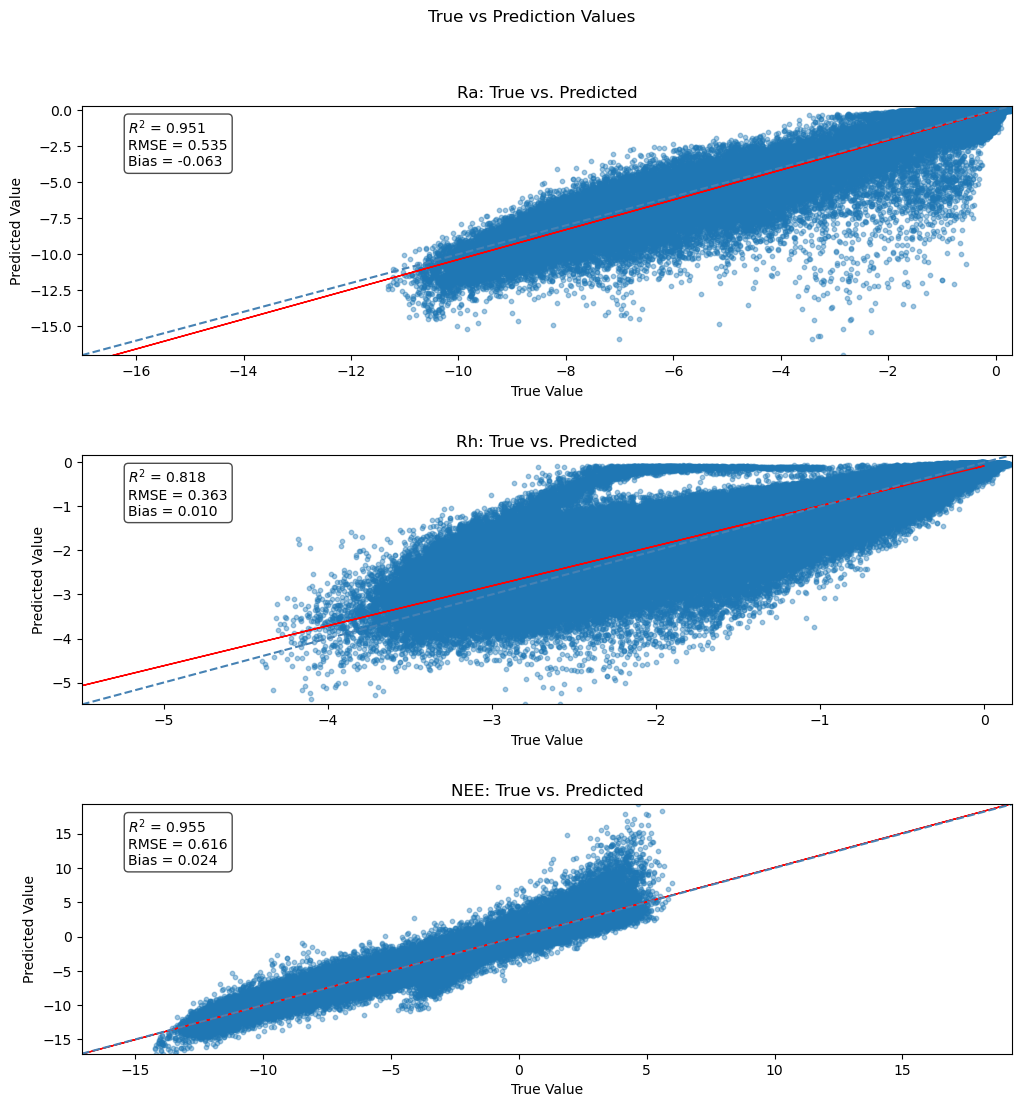

In [17]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)